		~~~~~~~~~~~~~~~~~~~~~~~ Bullish for Date ~~~~~~~~~~~~~~~~~~~~~~~~~ 

Using Current Market Price


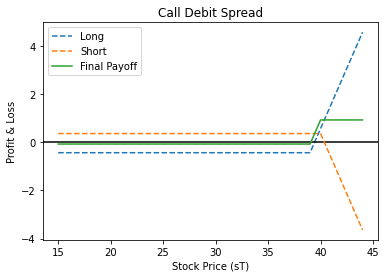

Best Call Debit Spread:  {'Short(Sell)': 40.0, 'Long(Buy)': 39.0, 'Risk/Reward Ratio': 0.06976744186046513, 'Short Premium': 0.36, 'Long Premium': 0.435, 'maxRisk': 0.07500000000000001, 'maxReward': 1.075}


Using Current Market Price


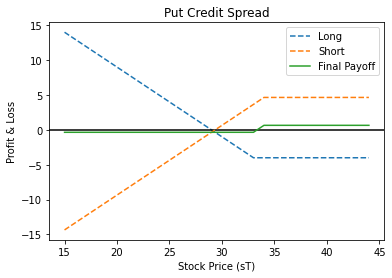

Best Put Credit Spread:  {'Short(Sell)': 34.0, 'Long(Buy)': 33.0, 'Risk/Reward Ratio': 2.5384615384615374, 'Short Premium': 4.65, 'Long Premium': 4.0, 'maxRisk': 1.6500000000000004, 'maxReward': 0.6500000000000004}


		~~~~~~~~~~~~~~~~~~~~~~~ Bearish for Date ~~~~~~~~~~~~~~~~~~~~~~~~~~ 

Using Current Market Price


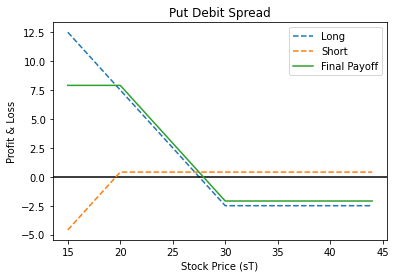



Using Current Market Price


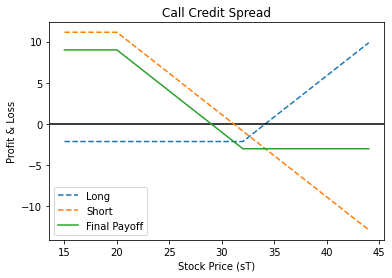

Best Call Credit Spread:  {'Short(Sell)': 20.0, 'Long(Buy)': 32.0, 'Risk/Reward Ratio': 0.3363028953229398, 'Short Premium': 11.125, 'Long Premium': 2.145, 'maxRisk': 3.0199999999999996, 'maxReward': 8.98}


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.3f}'.format
import numpy as np
import yfinance as yf
import pytz
import datetime
from os import system, name
stock =''
def setstock(st):
    global stock
    stock = st
setstock('UCO')
def getDataPut():
    date = '2020-08-21'
    s = yf.Ticker(stock)
    currentPrice = s.history(period = "max")['Close'].iloc[-1]
    oldPrice = s.history(period = "max")['Low'].iloc[-20]
    priceRange = currentPrice - oldPrice
    opt = s.option_chain(date)
    puts =  opt.puts
    puts['Fair Price']  = [i if i >= 0.01 else 0.01 for i in (puts['ask'] + puts['bid'])/2]
    return puts

def getDataCall():
    date = '2020-08-21'
    s = yf.Ticker(stock)
    currentPrice = s.history(period = "max")['Close'].iloc[-1]
    oldPrice = s.history(period = "max")['Low'].iloc[-20]
    priceRange = currentPrice - oldPrice
    opt = s.option_chain(date)
    calls, puts = opt.calls, opt.puts
    calls['Fair Price'] = [i if i >= 0.01 else 0.01 for i in (calls['ask']+calls['bid'])/2]
    return calls

def put_payoff(sT, k ,p):
    return np.where(sT<k, k-sT , 0)-p

def call_payoff(sT, k,p):
    return np.where(sT>k, sT-k , 0)-p

def getBounds(sK, lK, t):
    higher,lower = 0,0
    if t=="putC" or t=='callD':
        if currentPrice < sK:
            lower = currentPrice-priceRange
        else:
            lower = sK-priceRange
        if currentPrice>lK:
            higher = currentPrice +priceRange
        else:
            higher = lK +priceRange
    return upper,lower
   
def plotGraph(best_ratio, tittle, t):
    #long
    strike_price_long =best_ratio['Long(Buy)']
    premium_long= best_ratio['Long Premium']
    #Short
    strike_price_short = best_ratio['Short(Sell)']
    premium_short= best_ratio['Short Premium']
    #upper,lower = getBounds(strike_price_short,strike_price_long, t)
    #print(int(upper),int(lower))
    sT = np.arange(15,45,1)
    if t=='putC' or t=='putD':
        long_payoff = put_payoff(sT, strike_price_long,premium_long)
        short_payoff = put_payoff(sT, strike_price_short,premium_short)*-1
    if t== 'callC' or t=='callD':
        long_payoff = call_payoff(sT, strike_price_long,premium_long)
        short_payoff = call_payoff(sT, strike_price_short,premium_short)*-1
    final_payoff = short_payoff+long_payoff
    #plotting details
    fig, ax = plt.subplots()
    ax.plot(sT,long_payoff,'--', label = 'Long')
    plt.axhline(color='black')
    ax.plot(sT,short_payoff, '--', label = 'Short')
    ax.plot(sT,final_payoff, label = 'Final Payoff')
    plt.xlabel('Stock Price (sT)')
    plt.ylabel('Profit & Loss')
    ax.set_title(tittle)
    plt.legend()
    plt.show() 
def getCalls(calls):
    c = calls[calls['volume']>=int(calls['volume'].mean())]
#     if t == 'Credit':
#         c = calls[calls['inTheMoney'] == False]
    l = c[['strike', 'Fair Price']]
    j = c[['strike', 'lastPrice']]
    if c['ask'].mean() != 0: #need to use time library for 
        m = l.set_index('strike').to_dict()
        n = m['Fair Price'] 
        print("Using Current Market Price")
    else:
        m = j.set_index('strike').to_dict()
        n = m['lastPrice']
        print("Using Last Price")
    return n
def getPuts(puts):
    p = puts[puts['volume']>=int(puts['volume'].mean())]
    l = p[['strike', 'Fair Price']]
    j = p[['strike', 'lastPrice']]
    if p['ask'].mean() != 0:
        m = l.set_index('strike').to_dict()
        n = m['Fair Price'] 
        print("Using Current Market Price")
    else:
        m = j.set_index('strike').to_dict()
        n = m['lastPrice']
        print("Using Last Price")
    return n

def appendBest(best_ratio, l, s, lp, sp, r, mrx, mrw):
    best_ratio['Long(Buy)']=l
    best_ratio['Short(Sell)']=s
    best_ratio['Risk/Reward Ratio']=r
    best_ratio['Short Premium'] =sp
    best_ratio['Long Premium'] = lp
    best_ratio['maxRisk'] = mrx
    best_ratio['maxReward'] = mrw

    
def rnR(type, sL, sS, pL, pS):
    if type == 'callC' or type == 'putC':
        MaxReward = pS - pL
        MaxRisk = (sL - sS - MaxReward)
        if type == 'putC':
            MaxRisk *= -1
    if type == 'callD' or type == 'putD':
#         print(sL,  sS)
        MaxRisk = pL - pS
#         print(MaxRisk)
        MaxReward = (sL - sS) - MaxRisk
        if type == 'callD':
            MaxReward *= -1
    return MaxRisk, MaxReward

#Spread 1
def Call_Credit_Spread():
    calls = getDataCall()
    n = getCalls(calls)
#     We need to check the risk, reward, break even point
#     Then we need to check the ratio of the risk/reward
#     Then we need to store the 'Transaction' of the least ratio
# best_ratio: Dictionary to maintain the best available trade at a given time
    best_ratio = {'Short(Sell)':0, 'Long(Buy)':0, 'Risk/Reward Ratio':((2**31)-1), 'Short Premium':0, 'Long Premium':0, 'maxRisk':0, 'maxReward':0}
    # First loop to check what to short (sell)   
    for short in n:
        # Second loop to check what we're buying (long)
        for long in n:
            # In a credit call spread the long Strike cannot be lower or equal to the short strike price
            if long <= short:
                continue
            else:
                # Declaring variables to work with
                strikeShort = short
                strikeLong = long
                
                premiumShort = n[short]
                premiumLong = n[long]
                
                # Figuring out the max risk vs reward in each spread to minimise the risk/reward ratio.
                z = rnR('callC', strikeLong, strikeShort, premiumLong, premiumShort)
                MaxRisk = z[0]
                MaxReward = z[1]
                
                if MaxReward>0:
                    Ratio =  MaxRisk/MaxReward
                    if Ratio < best_ratio['Risk/Reward Ratio']:
                        appendBest(best_ratio, long, short, premiumLong, premiumShort, Ratio, MaxRisk, MaxReward)
                        
    plotGraph(best_ratio, 'Call Credit Spread', 'callC')
    return print("Best Call Credit Spread: ", best_ratio)
# setstock('UCO')
# Call_Credit_Spread ()
#Spread 2
def Put_Credit_Spread():
    puts = getDataPut()
    n = getPuts(puts)
#     We need to check the risk, reward, break even point
#     Then we need to check the ratio of the risk/reward
#     Then we need to store the 'Transaction' of the least ratio
#     best_ratio: Dictionary to maintain the best available trade at a given time
    best_ratio = {'Short(Sell)':0, 'Long(Buy)':0, 'Risk/Reward Ratio':((2**31)-1), 'Short Premium':0, 'Long Premium':0, 'maxRisk':0, 'maxReward':0}
    
    # First loop to check what to long (buy) 
    for long in n:
        # Second loop to check what we're selling(short)
        for short in n:
            # In a put credit spread the strike price of what we're buying cannot be higher than strike price of what we're selling
            if long >= short:
                continue
            
            else:
                #Decalring various variables
                strikeShort = short
                strikeLong = long
                premiumShort = n[short]
                premiumLong = n[long]
                
                #figuring out the max risk vs reward in each spread to minimise the risk/reward ratio.
                z = rnR('putC', strikeLong, strikeShort, premiumLong, premiumShort)
                MaxRisk = z[0]
                MaxReward = z[1]
                
                if MaxReward>0:
                    Ratio =  MaxRisk/MaxReward
                    if Ratio < best_ratio['Risk/Reward Ratio']:
                        appendBest(best_ratio, long, short, premiumLong, premiumShort, Ratio, MaxRisk, MaxReward)

    plotGraph(best_ratio, 'Put Credit Spread', 'putC' )                                      
    return print("Best Put Credit Spread: ", best_ratio)

#Spread 3
def Call_Debit_Spread():
    calls = getDataCall()
    n = getCalls(calls)
#     We need to check the risk, reward, break even point
#     Then we need to check the ratio of the risk/reward
#     Then we need to store the 'Transaction' of the least ratio
    best_ratio = {'Short(Sell)':0, 'Long(Buy)':0, 'Risk/Reward Ratio':((2**31)-1), 'Short Premium':0, 'Long Premium':0, 'maxRisk':0, 'maxReward':0}
    # First loop to check what we're buying
    for long in n:
        # Second loop for what we're selling
        for short in n:
            # We don't want buying strike to be higher than selling strike (Call debit, sell higher strike and buy lower strike)
            if long >= short:
                continue
            else:
                
                #Declaring variables
                strikeShort = short
                strikeLong = long
                premiumShort = n[short]
                premiumLong = n[long]
                
                z = rnR('callD', strikeLong, strikeShort, premiumLong, premiumShort)
                MaxRisk = z[0]
                MaxReward = z[1]
                            
                if MaxReward > 0:
                    Ratio =  MaxRisk/MaxReward
                    if Ratio < best_ratio['Risk/Reward Ratio']:
                        appendBest(best_ratio, long, short, premiumLong, premiumShort, Ratio, MaxRisk, MaxReward)


                        
    plotGraph(best_ratio, 'Call Debit Spread', 'callC')                    
    return print("Best Call Debit Spread: ", best_ratio)


#Spread 4
def Put_Debit_Spread():
    puts = getDataPut()
    n = getPuts(puts)
#     We need to check the risk, reward, break even point
#     Then we need to check the ratio of the risk/reward
#     Then we need to store the 'Transaction' of the least ratio

    # best_ratio: Dictionary to maintain the best available trade at a given time
    best_ratio = {'Short(Sell)':0, 'Long(Buy)':0, 'Risk/Reward Ratio':((2**31)-1), 'Short Premium':0, 'Long Premium':0, 'maxRisk':0, 'maxReward':0}
    
    # First loop to check what we're buying
    for long in n:
        
        # Second loop for what we're selling
        for short in n:
            
            # We don't want buying strike to be smaller than selling strike (Put debit, buy higher strike and sell lower strike)
            if long <= short:
                continue
            else:
                
                #Declaring variables
                strikeShort = short
                strikeLong = long
                premiumShort = n[short]
                premiumLong = n[long]
                
                # figuring out the max risk vs reward in each spread to minimise the risk/reward ratio.
                z = rnR('putD', strikeLong, strikeShort, premiumLong, premiumShort)
                MaxRisk = z[0]
                MaxReward = z[1]
        
                if MaxReward>0:
                    Ratio =  MaxRisk/MaxReward
                    if Ratio < best_ratio['Risk/Reward Ratio']:
                        appendBest(best_ratio, long, short, premiumLong, premiumShort, Ratio, MaxRisk, MaxReward)

                        
    plotGraph(best_ratio, 'Put Debit Spread', 'putD')  
    return ("Best Put Debit Spread: ", best_ratio)

#Final Testing call for all spreads
def finalSpreads():
    print("\t\t~~~~~~~~~~~~~~~~~~~~~~~ Bullish for Date", "~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
    Call_Debit_Spread()
    print("\n")
    Put_Credit_Spread()
    print("\n")
    print("\t\t~~~~~~~~~~~~~~~~~~~~~~~ Bearish for Date" ,"~~~~~~~~~~~~~~~~~~~~~~~~~~ \n")
    Put_Debit_Spread()
    print("\n")
    Call_Credit_Spread()


finalSpreads()